Importing libraries

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import seaborn as sns
import re
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Extract data from file keeping only 4 columns

In [2]:
data = []

with open("Data/booksummaries/booksummaries.txt", encoding="utf8") as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

book_id = []
book_name = []
summary = []
genre = []

for i in tqdm(data):
    book_id.append(i[0])
    book_name.append(i[2])
    genre.append(i[5])
    summary.append(i[6])

books = pd.DataFrame({'book_id': book_id, 'book_name': book_name,
                       'genre': genre, 'summary': summary})

books.head(2)

16559it [00:00, 21363.96it/s]
100%|██████████| 16559/16559 [00:00<00:00, 1234026.51it/s]


,book_id,book_name,genre,summary
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."


In [3]:
# json genres example
json.loads(books['genre'][1]).values()

print(f'Dataset size before cleaning: {len(books)}')

# drop data where genre is empty
books.drop(books[books['genre']==''].index, inplace=True)

# drop data where summary is empty
books.drop(books[books['summary']==''].index, inplace=True)


print(f'Dataset size after cleaning: {len(books)}')

Dataset size before cleaning: 16559
Dataset size after cleaning: 12841


In [4]:
s = books.summary.str.len().sort_values().index
books = books.reindex(s)[900:]
print(f'Dataset size after cleaning: {len(books)}')

Dataset size after cleaning: 11941


Decode JSON format in 'genre' column to 'new_genre' column\
Create a dictionary with all genres as keys and their number of occurrence as values

In [5]:
genres = []
for i in books['genre']:
    x = list(json.loads(i).values())
    genres.append(x)
books['genre_new'] = genres

genres_sum = sum(genres,[])
all_genres = {}

for g in set(genres_sum):
    all_genres[g] = genres_sum.count(g)

all_genres = dict(sorted(all_genres.items(), key=lambda x: x[1]))


Different genres count: 226
Top 40 popular genres:


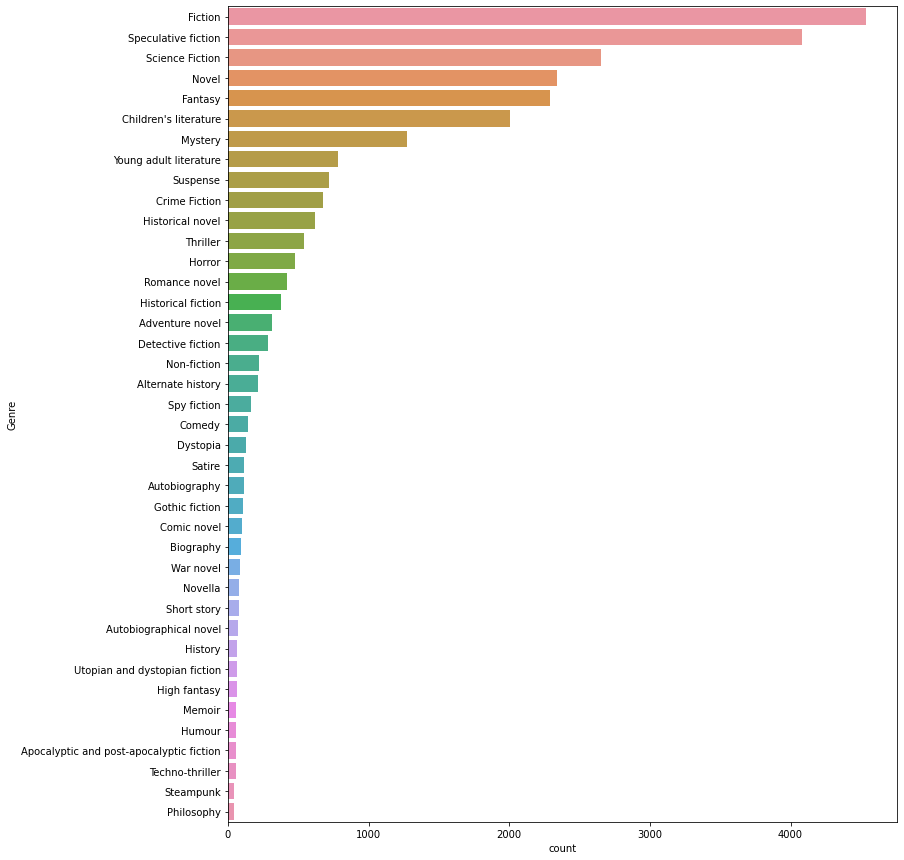

In [6]:
print(f'Different genres count: {len(all_genres)}')
print('Top 40 popular genres:')
vis = pd.DataFrame({'genre':list(all_genres.keys()), 'count':list(all_genres.values())}) 

# visualize genres and frequencies
dat = vis.nlargest(columns="count", n = 40) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=dat, x= "count", y = "genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [7]:
# remove_genres = list({key: value for key, value in all_genres.items() if value <= 700})
# remove_genres.append("Speculative fiction")
# all_genres = {key: value for key, value in all_genres.items() if value > 700}
# all_genres.pop('Speculative fiction')
genres_list = {"Fantasy", "Novel", "Crime Fiction", "Thriller", "Mystery"}
remove_genres = all_genres
for g in genres_list: 
    remove_genres.pop(g)
all_genres = genres_list

print(f'Remove genres number: {len(remove_genres)}')
print(f'All genres number: {len(all_genres)}')
print(all_genres)

Remove genres number: 221
All genres number: 5
{'Mystery', 'Fantasy', 'Crime Fiction', 'Thriller', 'Novel'}


In [8]:
# remove genres from dataset
for rem in remove_genres:
    i = 0
    for g in books['genre_new']:
        i += 1
        if rem in g: 
            g.remove(rem)

id_empty=[]
for id in books['book_id']:
    if books[books['book_id']==id]['genre_new'].tolist()[0] == []: 
        id_empty.append(id)

print(len(id_empty))

5895


In [9]:
# drop data where genre is empty
for id in id_empty:
    books.drop(books[books['book_id']==id].index, inplace=True)

genres = []
for i in books['genre_new']:
    x = list(i)[0]
    genres.append(x)
books['genre'] = genres

Preprocessing text functions:
- to lowercase
- remove everething except letters
- remove whitespaces 
- remove stop words
- text stemming (Porter)
<img src="https://user.oc-static.com/upload/2020/10/22/16033551309054_stemming%20example.png" alt="drawing" width="300"/>

In [10]:
def preprocess(text):
    text = re.sub("\'", "", str(text)) 
    text = re.sub("[^a-zA-Z]", " ", str(text)) 
    text = ' '.join(text.split()) 
    text = text.lower() 

    return text

books['clear_summary'] = books['summary'].apply(lambda x: preprocess(x))

In [11]:
# Removing stop words ("a", "an"...)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['clear_summary'] = books['clear_summary'].apply(lambda x: remove_stopwords(x))

In [12]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming(text):
    stemText = ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemText += stem
        stemText += " "
    stemText = stemText.strip()
    return stemText

books['clear_summary'] = books['clear_summary'].apply(lambda x: stemming(x))

In [13]:
# After summary preprocessing
print(f'data size: {len(books)}')
books.groupby('genre').count()

data size: 6046


,book_id,book_name,summary,genre_new,clear_summary
genre,,,,,
Crime Fiction,606,606,606,606,606
Fantasy,2144,2144,2144,2144,2144
Mystery,750,750,750,750,750
Novel,2004,2004,2004,2004,2004
Thriller,542,542,542,542,542


Encode target labels with value between 0 and n_classes-1.

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(books['genre'])
encoder.inverse_transform([0,1,2,3,4])

array(['Crime Fiction', 'Fantasy', 'Mystery', 'Novel', 'Thriller'],
      dtype=object)

Convert text to numbers using TFIDF (term frequency–inverse document frequency) approach

+ **Term frequency** = (Number of Occurrences of a word)/(Total words in the document)
+ **IDF(word)** = Log((Total number of documents)/(Number of documents containing the word))

*max_features* - equal to 4000, which means we want to use the 4000 most frequently occurring words as features to train our classifier.\
*min_df* - ignore terms that have a document frequency strictly lower than the given number\
*max_df* - include only those words that appear in a maximum of 65% of all documents\
(Words that appear in almost every document are usually not suitable for classification because they do not provide any unique information about the document)

In [28]:
tfidfconverter = TfidfVectorizer(max_features=4000, min_df=10, max_df=0.65)
X = tfidfconverter.fit_transform(books['clear_summary'])

Splitting data into training and test sets (90%/10%)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

1. Naive Bayes Classifier Algorithm

In [30]:
# fitting the classification model
classifier_nb = naive_bayes.MultinomialNB()

# x10 cross validation
cv_results = cross_validate(classifier_nb, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best model: {index_best}')
classifier_nb = cv_results['estimator'][index_best]

# predict genre on test dataset
y_pred = classifier_nb.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

print(y_test[:15])
print(y_pred[:15])

[0.68256881 0.71139706 0.69485294 0.69117647 0.68566176 0.68933824
 0.70588235 0.71139706 0.71691176 0.72058824]
best model: 9
              precision    recall  f1-score   support

           0       0.89      0.48      0.63        66
           1       0.84      0.91      0.87       228
           2       0.86      0.38      0.53        81
           3       0.59      0.86      0.70       187
           4       0.82      0.21      0.33        43

    accuracy                           0.73       605
   macro avg       0.80      0.57      0.61       605
weighted avg       0.77      0.73      0.71       605

Accurancy 0.7289256198347107
[3 1 3 3 0 2 3 1 3 1 3 1 3 1 1]
[3 1 3 3 0 3 3 1 3 1 3 1 3 1 1]


2. SVM algorithm using the RBF (Gaussian) kernel (Gamma = 1, default C = 10)

In [31]:
# fitting the classification model
classifier_svc = svm.SVC(C = 10, kernel='rbf',gamma=1)

# x10 cross validation
cv_results = cross_validate(classifier_svc, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best model: {index_best}')
classifier_svc = cv_results['estimator'][index_best]

y_pred=classifier_svc.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

[0.73577982 0.75367647 0.73161765 0.74448529 0.71507353 0.74264706
 0.74080882 0.72977941 0.76286765 0.76286765]
best model: 8
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        66
           1       0.84      0.90      0.87       228
           2       0.76      0.46      0.57        81
           3       0.66      0.80      0.72       187
           4       0.73      0.51      0.60        43

    accuracy                           0.76       605
   macro avg       0.76      0.67      0.70       605
weighted avg       0.76      0.76      0.75       605

Accurancy 0.7570247933884298


SVM hyperparameters: Gamma = 0.1, C = 10

In [32]:
# fitting the classification model
classifier_svc = svm.SVC(C = 10, kernel='rbf',gamma=0.1)

# x5 cross validation
cv_results = cross_validate(classifier_svc, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best model: {index_best}')
classifier_svc = cv_results['estimator'][index_best]

y_pred=classifier_svc.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

[0.73211009 0.74264706 0.71875    0.73713235 0.73161765 0.73161765
 0.73345588 0.72977941 0.73897059 0.75      ]
best model: 9
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        66
           1       0.84      0.90      0.87       228
           2       0.70      0.46      0.55        81
           3       0.71      0.78      0.74       187
           4       0.59      0.60      0.60        43

    accuracy                           0.75       605
   macro avg       0.71      0.68      0.69       605
weighted avg       0.75      0.75      0.75       605

Accurancy 0.7537190082644628


SVM hyperparameters: Gamma = 10, C = 10

In [33]:
# fitting the classification model
classifier_svc = svm.SVC(C = 10, kernel='rbf',gamma=10)

# x5 cross validation
cv_results = cross_validate(classifier_svc, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best: {index_best}')
classifier_svc = cv_results['estimator'][index_best]

y_pred=classifier_svc.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

[0.3559633  0.35294118 0.35110294 0.35110294 0.35294118 0.35294118
 0.35477941 0.35477941 0.35477941 0.35477941]
best: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.38      1.00      0.55       228
           2       0.00      0.00      0.00        81
           3       1.00      0.01      0.01       187
           4       0.00      0.00      0.00        43

    accuracy                           0.38       605
   macro avg       0.28      0.20      0.11       605
weighted avg       0.45      0.38      0.21       605

Accurancy 0.3785123966942149


c:\Users\Asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera